In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from pathlib import Path
import os
import sys
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
# load data 
base_path = Path.cwd().parent
data_dir = os.path.join(base_path, 'data', 'titanic.csv')
data = pd.read_csv(data_dir, index_col=0)
data.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
# select important features 
selected_columns = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
selected_data = data[selected_columns].copy()

In [4]:
# check for missing values
def check_missing_values(df):
    for col in df.columns:
        missing_values = df[col].isnull().sum()
        if missing_values > 0:
            print(f'{col} has {missing_values} missing values')
            
check_missing_values(selected_data)

Age has 177 missing values
Embarked has 2 missing values


In [5]:
# impute missing values

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
selected_data[['Age', 'Fare']] = imputer.fit_transform(selected_data[['Age', 'Fare']])

In [6]:
numerical_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Sex', 'Embarked']

In [7]:
# encode categorical variables and prepare data for training
preprocessor = ColumnTransformer(
    [
        ('onehot', OneHotEncoder(sparse_output=False), categorical_features),
        ('scaler', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

In [8]:
prepared_data = preprocessor.fit_transform(selected_data)

In [9]:
feature_names = preprocessor.get_feature_names_out()

In [10]:
preprocessor.get_feature_names_out()

array(['onehot__Sex_female', 'onehot__Sex_male', 'onehot__Embarked_C',
       'onehot__Embarked_Q', 'onehot__Embarked_S', 'onehot__Embarked_nan',
       'scaler__Pclass', 'scaler__Age', 'scaler__SibSp', 'scaler__Parch',
       'scaler__Fare', 'remainder__Survived'], dtype=object)

In [11]:
X = prepared_data[:, :-1]
y = prepared_data[:, -1]

In [12]:
# split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# val split 
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.2, random_state=42)

In [14]:
# create a train model 
model = tf.keras.models.Sequential([tf.keras.layers.Dense(8, activation='linear', input_shape=(X_train.shape[1],)),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(4, activation='relu'),
                                    tf.keras.layers.Dropout(0.1),
                                    tf.keras.layers.Dense(1, activation='sigmoid')])

In [15]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# train the model
history = model.fit(X_train, 
                    y_train, 
                    epochs=100,
                    validation_data=(X_val, y_val))

Epoch 1/100


18/18 [==============================] - 1s 13ms/step - loss: 0.7607 - accuracy: 0.4359 - val_loss: 0.7260 - val_accuracy: 0.4406
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 0.7286 - accuracy: 0.4956 - val_loss: 0.6991 - val_accuracy: 0.4825
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 0.7248 - accuracy: 0.5114 - val_loss: 0.6819 - val_accuracy: 0.5594
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6962 - accuracy: 0.5589 - val_loss: 0.6692 - val_accuracy: 0.5874
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5589 - val_loss: 0.6575 - val_accuracy: 0.6224
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6750 - accuracy: 0.6362 - val_loss: 0.6446 - val_accuracy: 0.6923
Epoch 7/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6597 - accuracy: 0.6520 - val_loss: 0.6302 - val_accuracy: 0.7203
Epoch 8/10

In [17]:
# save the model
target_dir = os.path.join(base_path, 'models')
model.save(os.path.join(target_dir,'titanic_model.tf'))

INFO:tensorflow:Assets written to: c:\Users\victorhu.contrera\Documents\pro_dexire\pro_DEXiRE\models\titanic_model.tf\assets


INFO:tensorflow:Assets written to: c:\Users\victorhu.contrera\Documents\pro_dexire\pro_DEXiRE\models\titanic_model.tf\assets


In [18]:
from sklearn.metrics import (accuracy_score, 
                             precision_recall_curve, 
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             classification_report, 
                             ConfusionMatrixDisplay,
                             confusion_matrix)

In [19]:
# eval the model 
y_pred = model.predict(X_test)
y_pred_classes = np.rint(y_pred)

6/6 [==============================] - 0s 1ms/step


In [20]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

         0.0       0.78      0.89      0.83       105
         1.0       0.80      0.65      0.72        74

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.77       179
weighted avg       0.79      0.79      0.78       179



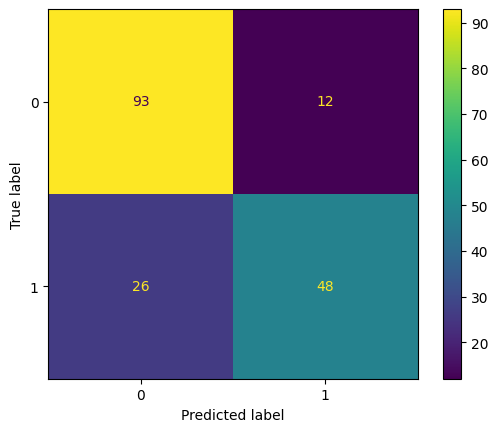

In [21]:
cn = confusion_matrix(y_test, y_pred_classes)
ConfusionMatrixDisplay(cn).plot()

In [22]:
import sys
import os
sys.path.insert(0, os.path.join(base_path))

In [23]:
sys.path

['c:\\Users\\victorhu.contrera\\Documents\\pro_dexire\\pro_DEXiRE',
 'c:\\Users\\victorhu.contrera\\Anaconda3\\envs\\prodexire\\python310.zip',
 'c:\\Users\\victorhu.contrera\\Anaconda3\\envs\\prodexire\\DLLs',
 'c:\\Users\\victorhu.contrera\\Anaconda3\\envs\\prodexire\\lib',
 'c:\\Users\\victorhu.contrera\\Anaconda3\\envs\\prodexire',
 '',
 'c:\\Users\\victorhu.contrera\\Anaconda3\\envs\\prodexire\\lib\\site-packages',
 'c:\\Users\\victorhu.contrera\\Anaconda3\\envs\\prodexire\\lib\\site-packages\\win32',
 'c:\\Users\\victorhu.contrera\\Anaconda3\\envs\\prodexire\\lib\\site-packages\\win32\\lib',
 'c:\\Users\\victorhu.contrera\\Anaconda3\\envs\\prodexire\\lib\\site-packages\\Pythonwin']

In [24]:
from dexire.dexire import DEXiRE

In [25]:
target_dir = os.path.join(base_path, 'models')
model = tf.keras.models.load_model(os.path.join(target_dir, 'titanic_model.tf'))

In [26]:
dexire = DEXiRE(model=model, feature_names=feature_names[:-1], class_names=['Survived', 'Not Survived'])

In [27]:
rule_set = dexire.extract_rules(X_train, y_train)

18/18 [==============================] - 0s 947us/step
Unique predictions: [0. 1.]
18/18 [==============================] - 0s 824us/step
7
feature_7
Symbolic expression: feature_7 <= 0.5
4
feature_4
Symbolic expression: feature_4 <= 0.5
3
feature_3
Symbolic expression: feature_3 <= 0.5
Symbolic expression: feature_3 > 0.5
0
feature_0
Symbolic expression: feature_0 <= 0.5
1
feature_1
Symbolic expression: feature_1 <= 0.5
Symbolic expression: feature_1 > 0.5
Symbolic expression: feature_0 > 0.5
Symbolic expression: feature_4 > 0.5
5
feature_5
Symbolic expression: feature_5 <= 0.5
Symbolic expression: feature_5 > 0.5
3
feature_3
Symbolic expression: feature_3 <= 0.5
Symbolic expression: feature_3 > 0.5
0
feature_0
Symbolic expression: feature_0 <= 0.5
Symbolic expression: feature_0 > 0.5
Symbolic expression: feature_7 > 0.5
0
feature_0
Symbolic expression: feature_0 <= 0.5
Symbolic expression: feature_0 > 0.5
0
onehot__Sex_female
Symbolic expression: onehot__Sex_female <= 0.5
7
scaler__A

In [80]:
%load_ext autoreload
%autoreload 2
from dexire_pro.core.dexire_pro_pipeline import DexireProPipeline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
xai_pipeline = DexireProPipeline(model,
                                 feature_names=feature_names[:-1],
                                 target_names=['Survived', 'Not Survived'],
                                 categorical_features=categorical_features,
                                 numerical_features=numerical_features)
                                 

In [82]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test))
test_ds = test_ds.batch(32)

In [104]:
numerical_features_out = [f'{feature}' for feature in feature_names[:-1] if feature.split('_')[-1] in numerical_features]

In [107]:
categorical_out = list(set(feature_names[:-1])-set(numerical_features_out))

In [108]:
dict_pipeline = {'rule_extraction': {'tf_model_input': train_ds, 
                'X_train_xai': X_train,
                'y_train_xai': y_train,
                'tf_model_test_data': test_ds, 
                'X_test_xai': X_test,
                'y_test_xai': y_test,
                'layer_list': None,
                'xai_feature_names': feature_names[:-1]},
    'probabilistic_graphical_model': {
        'numeric_features':numerical_features_out,
        'categorical_features': categorical_out,
        'target_col': 'y_pred'
    }
}

In [112]:
xai_pipeline.full_pipeline(
    train_df=pd.DataFrame(X_train, columns=feature_names[:-1]),
    dict_steps_parameters=dict_pipeline
)

Rule extraction...
Not processing
Extracting rules...
18/18 [==============================] - 0s 824us/step
Unique predictions: [0. 1.]
18/18 [==============================] - 0s 766us/step
7
feature_7
Symbolic expression: feature_7 <= 0.5
4
feature_4
Symbolic expression: feature_4 <= 0.5
3
feature_3
Symbolic expression: feature_3 <= 0.5
Symbolic expression: feature_3 > 0.5
0
feature_0
Symbolic expression: feature_0 <= 0.5
1
feature_1
Symbolic expression: feature_1 <= 0.5
Symbolic expression: feature_1 > 0.5
Symbolic expression: feature_0 > 0.5
Symbolic expression: feature_4 > 0.5
5
feature_5
Symbolic expression: feature_5 <= 0.5
Symbolic expression: feature_5 > 0.5
3
feature_3
Symbolic expression: feature_3 <= 0.5
Symbolic expression: feature_3 > 0.5
0
feature_0
Symbolic expression: feature_0 <= 0.5
Symbolic expression: feature_0 > 0.5
Symbolic expression: feature_7 > 0.5
0
feature_0
Symbolic expression: feature_0 <= 0.5
Symbolic expression: feature_0 > 0.5
1
onehot__Sex_male
Symbol